In [3]:
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
import numpy as np
import pandas as pd
import lmfit as lmfit 

In [4]:
cols = ["q", "I"]
data = pd.read_csv("teshi_xs",names=cols,sep=" ")

In [5]:
data

,q,I
0,0.0071,200901.4022
1,0.0072,175225.2432
2,0.0074,162112.5351
3,0.0078,152125.3787
4,0.0081,140467.8535
...,...,...
113,0.2731,8.2556
114,0.2812,7.2004
115,0.2911,6.5849
116,0.2953,5.9275


### Fit using GP model + power law

In [6]:
def GuinierANDPorod(x,A,s,rg,m):
        result=x.copy()
        q2 = 1.0/rg*np.sqrt((m-s)*(3-s)/2)
        B = np.power(q2,m-s)*np.exp((-q2**2*rg**2)/(3-s))
        mask = result<q2
        result[mask] = np.power(x,-s)*np.exp((-x**2*rg**2)/(3-s))
        result[np.invert(mask)] = B*np.power(x,-m)
        return A*result

[66.40901846  1.50279313 14.64271592  4.14778786]
[2.12514024]
q2:  0.09609851492894372  C:  4.882528171671051  B:  0.00054317235738064
Relative diff. @q2:  -0.036371814321207244


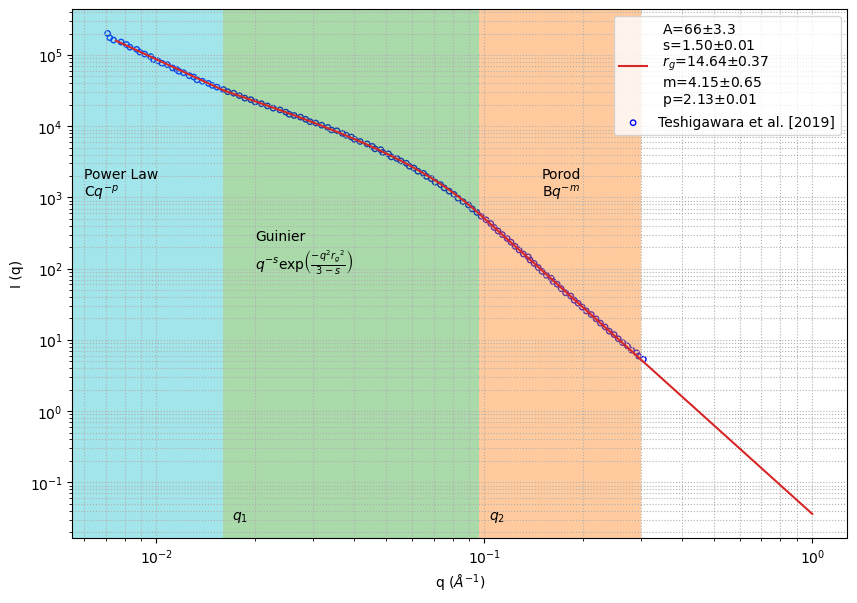

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=100)
q1=0.016
mask_fit_PL = (data["q"]>0.0072) & (data["q"]<q1)
mask_fit_guinierANDporod = (data["q"]>q1) & (data["q"]<0.3)

popt,pcov = curve_fit(GuinierANDPorod,
                      data["q"][mask_fit_guinierANDporod],
                      data["I"][mask_fit_guinierANDporod], 
                      p0=[1e2,1.4,16,3.7,],
                      bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr = np.sqrt(np.diag(pcov))
print(popt)

def power_law2(x,p):
    C = popt[0]*np.power(q1,p-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
    return C*np.power(x,-p)

popt2,pcov2 = curve_fit(power_law2,
                      data["q"][mask_fit_PL],
                      data["I"][mask_fit_PL], 
                      p0=[1],
                      bounds=((0), (np.inf)))
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data["q"],data["I"],s=15,facecolors='none',edgecolors="b",label="Teshigawara et al. [2019]")

x_fit = [x for x in np.linspace(q1,1,1000)]
y_fit=GuinierANDPorod(pd.Series(x_fit),*popt)
x_fit2 =[x for x in np.linspace(0.00752,q1,100)]
y_fit2=power_law2(pd.Series(x_fit2),*popt2)

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"
label_string_pl = f" p={popt2[0]:.2f}$\pm${perr2[0]:.2f}"

#Graphical decorators
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
#plt.vlines(q1,ymin,ymax)
ax.annotate(r'$q_1$',
            xy=(q1+0.001,0.03)
           )
ax.annotate('Power Law\n'+r'C$q^{-p}$', 
            xy=(0.006,1e3)
            )
plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
B = np.power(q2,popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
C = popt[0]*np.power(q1,popt2[0]-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
print("q2: ",q2, " C: ",C, " B: ",B)
print("Relative diff. @q2: ",(GuinierANDPorod(pd.Series([0.015]),*popt)[0] - power_law2(pd.Series([0.015]),*popt2)[0])/GuinierANDPorod(pd.Series([0.015]),*popt)[0])
#plt.vlines(q2,ymin,ymax)
ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$", 
            xy=(0.02,1e2)
            )
ax.annotate(f'$q_2$', 
            xy=(q2+0.007,0.03)
            )
plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
ax.annotate('Porod\n'+r'B$q^{-m}$', 
            xy=(0.15,1e3)
            )


plt.plot(x_fit,y_fit, c="tab:red", label=label_string_GP+label_string_pl)
plt.plot(x_fit2,y_fit2, c="tab:red",label=None)
plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("I (q)")
plt.yscale("log")
plt.grid(ls=":",which="both")
plt.savefig("Teshi_GP_and_PL.png",dpi=300)
plt.show()

### Residual

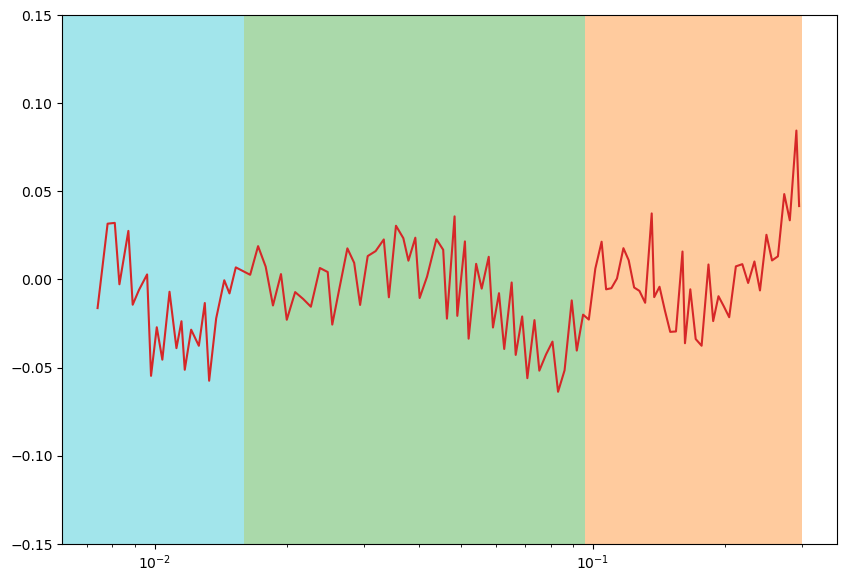

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=100)

residual_GP = (data["I"][mask_fit_guinierANDporod] - GuinierANDPorod(data["q"][mask_fit_guinierANDporod],*popt))/data["I"][mask_fit_guinierANDporod]
residual_pl = (data["I"][mask_fit_PL] - power_law2(data["q"][mask_fit_PL],*popt2))/data["I"][mask_fit_PL]

plt.plot(pd.concat([data["q"][mask_fit_PL],data["q"][mask_fit_guinierANDporod]]),pd.concat([residual_pl,residual_GP]), c="tab:red")
xmin, xmax = ax.get_xlim()
plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
plt.ylim(-0.15,0.15)
plt.xscale("log")

### Fit only GP

[66.40901846  1.50279313 14.64271592  4.14778786]
q2:  0.09609851492894372  B:  0.00054317235738064


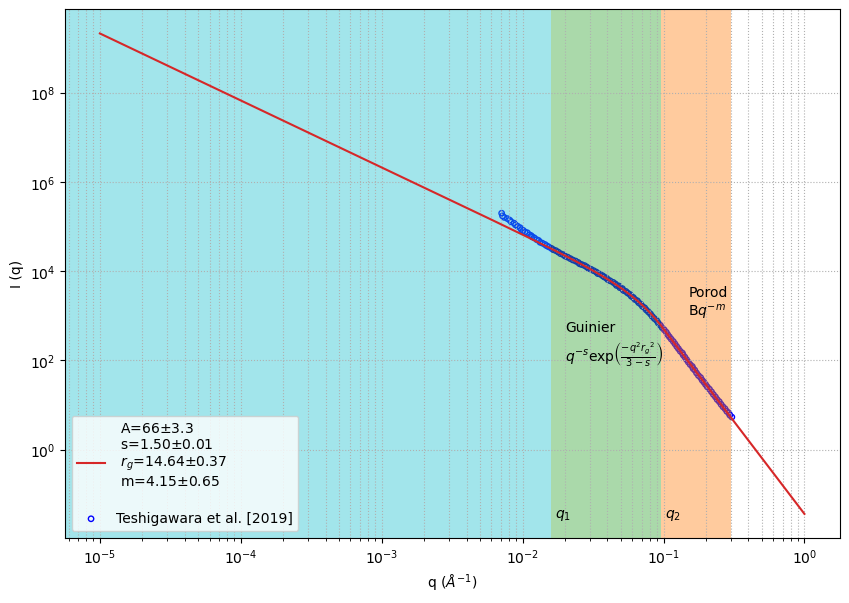

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=100)
q1=0.016
mask_fit_PL = (data["q"]>0.0072) & (data["q"]<q1)
mask_fit_guinierANDporod = (data["q"]>q1) & (data["q"]<0.3)

popt,pcov = curve_fit(GuinierANDPorod,
                      data["q"][mask_fit_guinierANDporod],
                      data["I"][mask_fit_guinierANDporod], 
                      p0=[1e2,1.4,16,3.7,],
                      bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr = np.sqrt(np.diag(pcov))
print(popt)

plt.scatter(data["q"],data["I"],s=15,facecolors='none',edgecolors="b",label="Teshigawara et al. [2019]")

x_fit = [x for x in np.linspace(1e-5,1,1000)]
y_fit=GuinierANDPorod(pd.Series(x_fit),*popt)

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"

#Graphical decorators
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
#plt.vlines(q1,ymin,ymax)
ax.annotate(r'$q_1$',
            xy=(q1+0.001,0.03)
           )
plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
B = np.power(q2,popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
print("q2: ",q2, " B: ",B)
#plt.vlines(q2,ymin,ymax)
ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$", 
            xy=(0.02,1e2)
            )
ax.annotate(f'$q_2$', 
            xy=(q2+0.007,0.03)
            )
plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
ax.annotate('Porod\n'+r'B$q^{-m}$', 
            xy=(0.15,1e3)
            )
y_approx =  [1.43934+x*(-00.55328) for x in x_fit]
plt.plot(x_fit,y_fit, c="tab:red", label=label_string_GP)
#plt.plot(x_fit,y_approx)
#plt.plot(x_fit2,y_fit2, c="tab:red",label=None)
plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("I (q)")
plt.yscale("log")
plt.grid(ls=":",which="both")
plt.savefig("Teshi_GP_only.png",dpi=300)
plt.show()


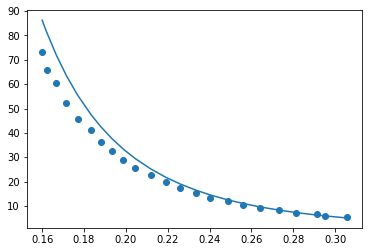

In [8]:
x = [0.1600,
0.1621,
0.1667,
0.1715,
0.1769,
0.1834,
0.1880,
0.1933,
0.1988,
0.2045,
0.2118,
0.2191,
0.2259,
0.2335,
0.2404,
0.2487,
0.2561,
0.2642,
0.2731,
0.2812,
0.2911,
0.2953,
0.3054]
y = [73.3235,
65.9727,
60.5311,
52.3384,
45.8544,
41.3170,
36.1124,
32.6291,
28.8805,
25.5294,
22.7149,
19.7616,
17.2231,
15.1993,
13.2499,
11.8828,
10.3672,
9.1327,
8.2556,
7.2004,
6.5849,
5.9275,
5.3606]

plt.scatter(x,y)
y_approx =  [0.028*x0**(-4.38328) for x0 in x]
plt.plot(x,y_approx)

In [96]:
x0 =2
0.028*x0**(-4.38328)


0.0013417119008729034

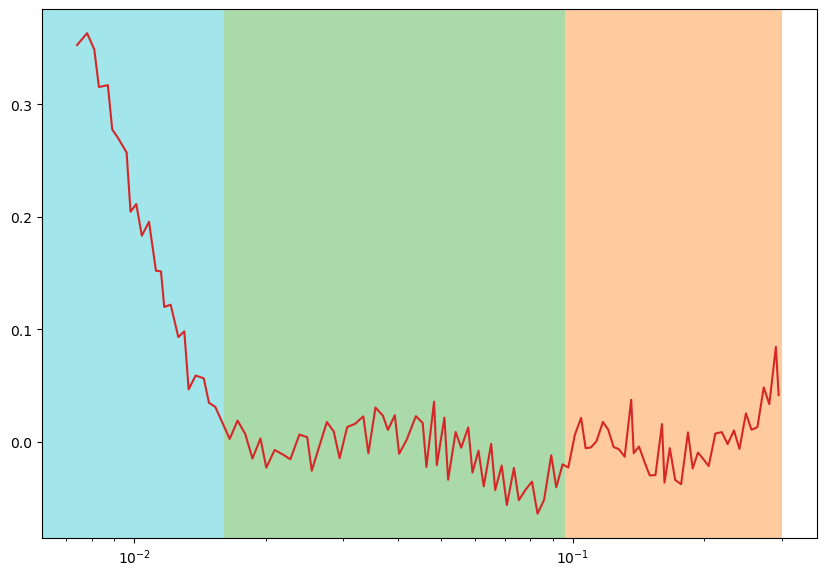

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=100)

residual_GP = (data["I"][mask_fit_guinierANDporod] - GuinierANDPorod(data["q"][mask_fit_guinierANDporod],*popt))/data["I"][mask_fit_guinierANDporod]
residual_pl = (data["I"][mask_fit_PL] - GuinierANDPorod(data["q"][mask_fit_PL],*popt))/data["I"][mask_fit_PL]

plt.plot(pd.concat([data["q"][mask_fit_PL],data["q"][mask_fit_guinierANDporod]]),pd.concat([residual_pl,residual_GP]), c="tab:red")
xmin, xmax = ax.get_xlim()
plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
#plt.ylim(-0.15,0.15)
plt.xscale("log")

### Modeling for plugin

In [126]:
cols = ["q", "I","I_min","I_max"]
data_ersez = pd.read_csv("Ersez_data_corr_wError",names=cols,sep="\t")

In [120]:
def piecewise_power(x,A1,b1,A2,b2,q0):
    if x<q0:
        return A1*np.power(x,-b1)
    else:
        return A2*np.power(x,-b2)

[66.40901846  1.50279313 14.64271592  4.14778786]
[2.12514024]


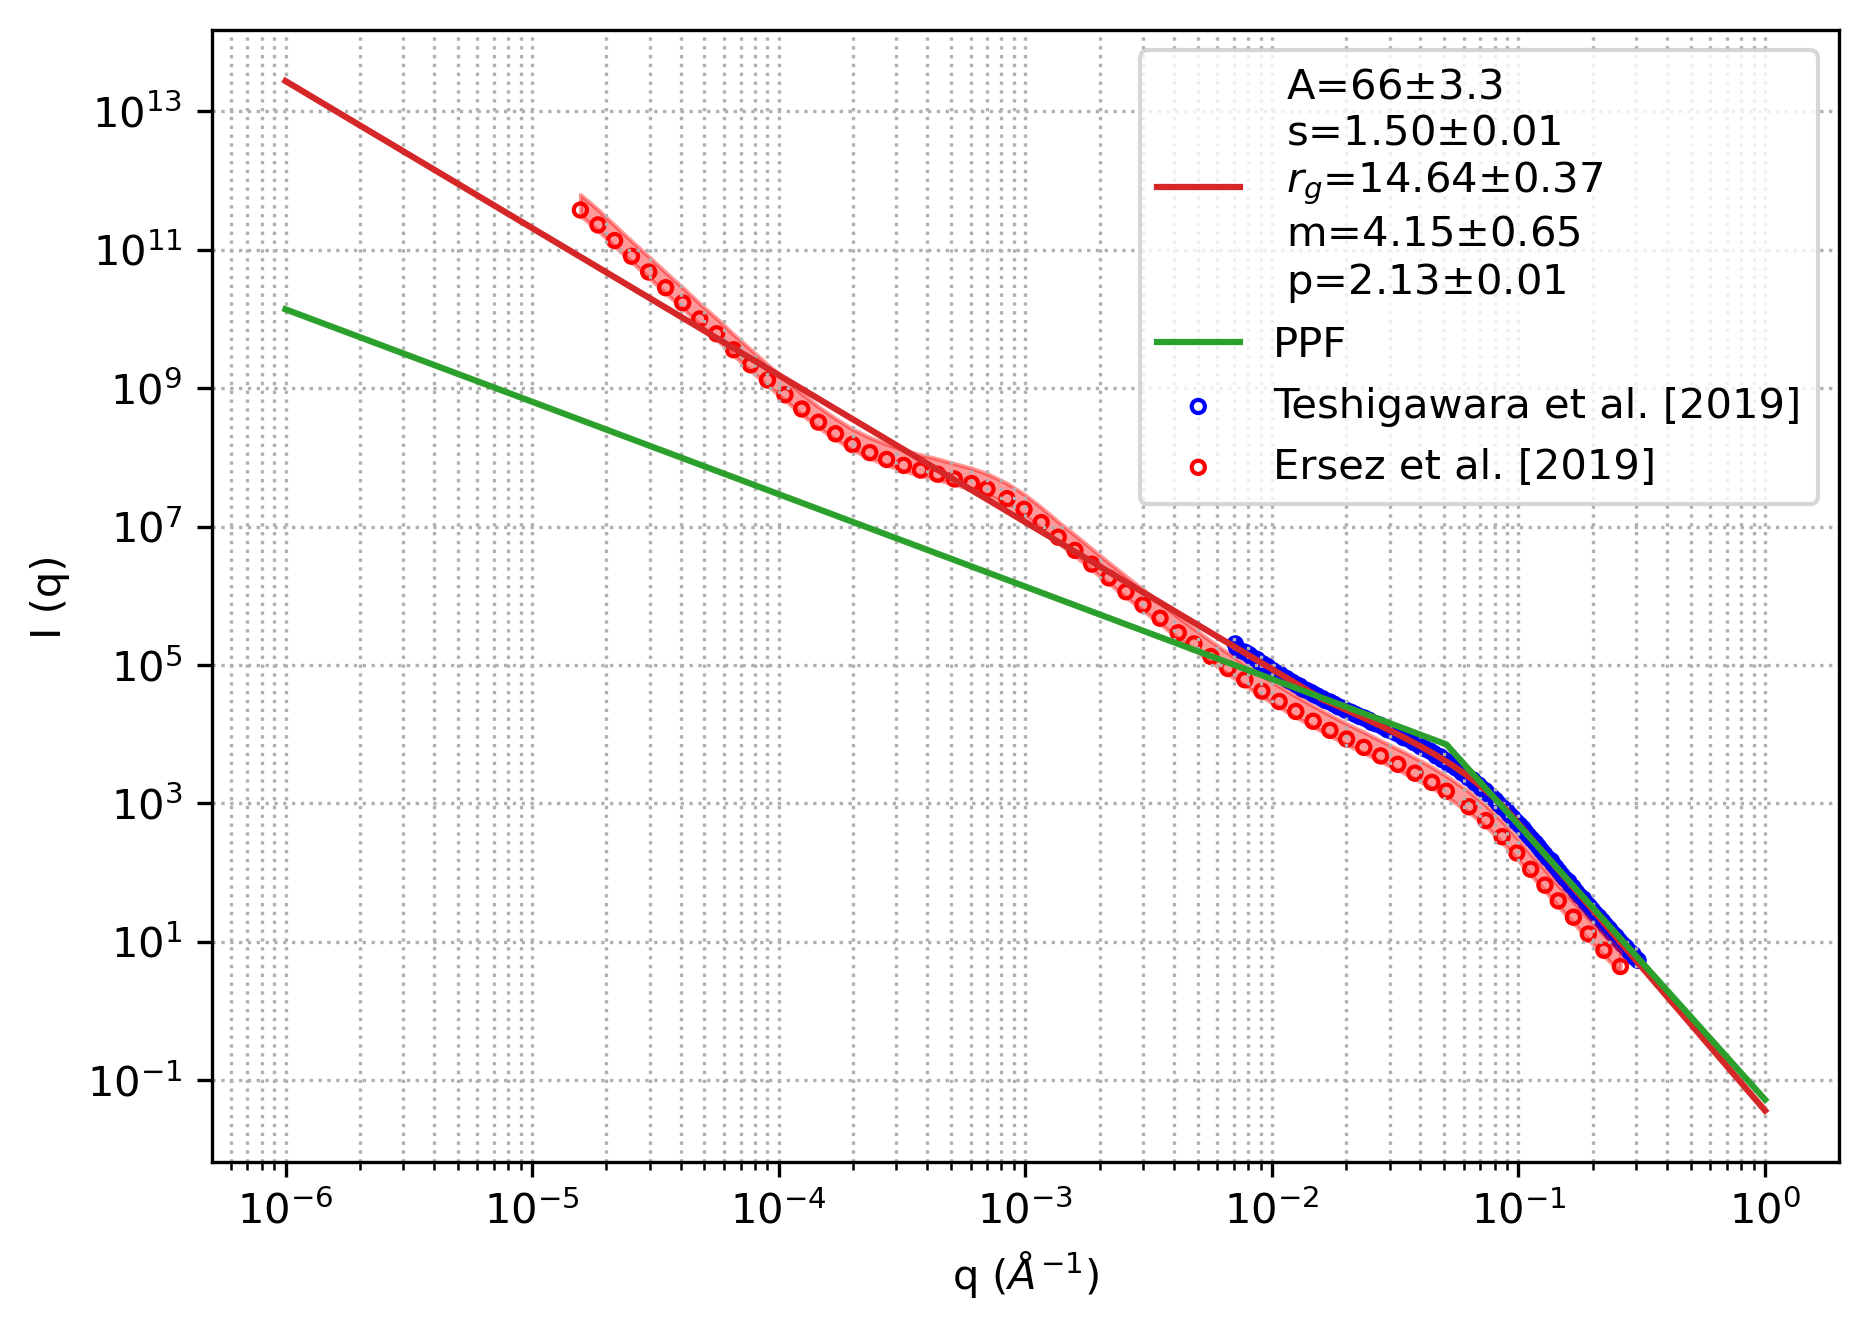

In [131]:
fig, ax = plt.subplots(1,1, figsize=(7, 5), dpi=300)
q1=0.016
mask_fit_PL = (data["q"]>0.0072) & (data["q"]<q1)
mask_fit_guinierANDporod = (data["q"]>q1) & (data["q"]<0.3)

popt,pcov = curve_fit(GuinierANDPorod,
                      data["q"][mask_fit_guinierANDporod],
                      data["I"][mask_fit_guinierANDporod], 
                      p0=[1e2,1.4,16,3.7,],
                      bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr = np.sqrt(np.diag(pcov))
print(popt)

def power_law2(x,p):
    C = popt[0]*np.power(q1,p-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
    return C*np.power(x,-p)

popt2,pcov2 = curve_fit(power_law2,
                      data["q"][mask_fit_PL],
                      data["I"][mask_fit_PL], 
                      p0=[1],
                      bounds=((0), (np.inf)))
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data["q"],data["I"],s=10,facecolors='none',edgecolors="b",label="Teshigawara et al. [2019]")
plt.scatter(data_ersez["q"],data_ersez["I"],s=10,facecolors='none',edgecolors="r",label="Ersez et al. [2019]")
plt.fill_between(data_ersez["q"], data_ersez["I_min"], data_ersez["I_max"], color="r",alpha=0.4)

x_fit = [x for x in np.linspace(q1,1,1000)]
y_fit=GuinierANDPorod(pd.Series(x_fit),*popt)
x_fit2 =[x for x in np.linspace(1e-6,q1,100)]
y_fit2=power_law2(pd.Series(x_fit2),*popt2)

A1=132.869
b1=1.33605
A2=0.0519763
b2=3.97314
Q0=0.0510821

x_fit_PPF = [x for x in np.logspace(-6,0,10000)]
y_fit_PPF = [piecewise_power(x,A1,b1,A2,b2,Q0) for x in x_fit_PPF]

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"
label_string_pl = f" p={popt2[0]:.2f}$\pm${perr2[0]:.2f}"

#Graphical decorators
#ymin, ymax = ax.get_ylim()
#xmin, xmax = ax.get_xlim()
#plt.vlines(q1,ymin,ymax)
#ax.annotate(r'$q_1$',
#            xy=(q1+0.001,0.03)
#           )
#ax.annotate('Power Law\n'+r'C$q^{-p}$', 
#            xy=(0.006,1e3)
#            )
#plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
#q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
#B = np.power(q2,popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
#C = popt[0]*np.power(q1,popt2[0]-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
#print("q2: ",q2, " C: ",C, " B: ",B)
#print("Relative diff. @q2: ",(GuinierANDPorod(pd.Series([0.015]),*popt)[0] - power_law2(pd.Series([0.015]),*popt2)[0])/GuinierANDPorod(pd.Series([0.015]),*popt)[0])
#plt.vlines(q2,ymin,ymax)
#ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$", 
#            xy=(0.02,1e2)
#            )
#ax.annotate(f'$q_2$', 
#            xy=(q2+0.007,0.03)
#            )
#plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
#plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
#ax.annotate('Porod\n'+r'B$q^{-m}$', 
#            xy=(0.15,1e3)
#            )


plt.plot(x_fit,y_fit, c="tab:red", label=label_string_GP+label_string_pl)
plt.plot(x_fit2,y_fit2, c="tab:red",label=None)
plt.plot(x_fit_PPF,y_fit_PPF, c="tab:green",label="PPF")
plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("I (q)")
plt.yscale("log")
plt.grid(ls=":",which="both")
#plt.savefig("Teshi_GP_and_PL.png",dpi=300)
plt.show()

[66.40901846  1.50279313 14.64271592  4.14778786]
[2.12514024]


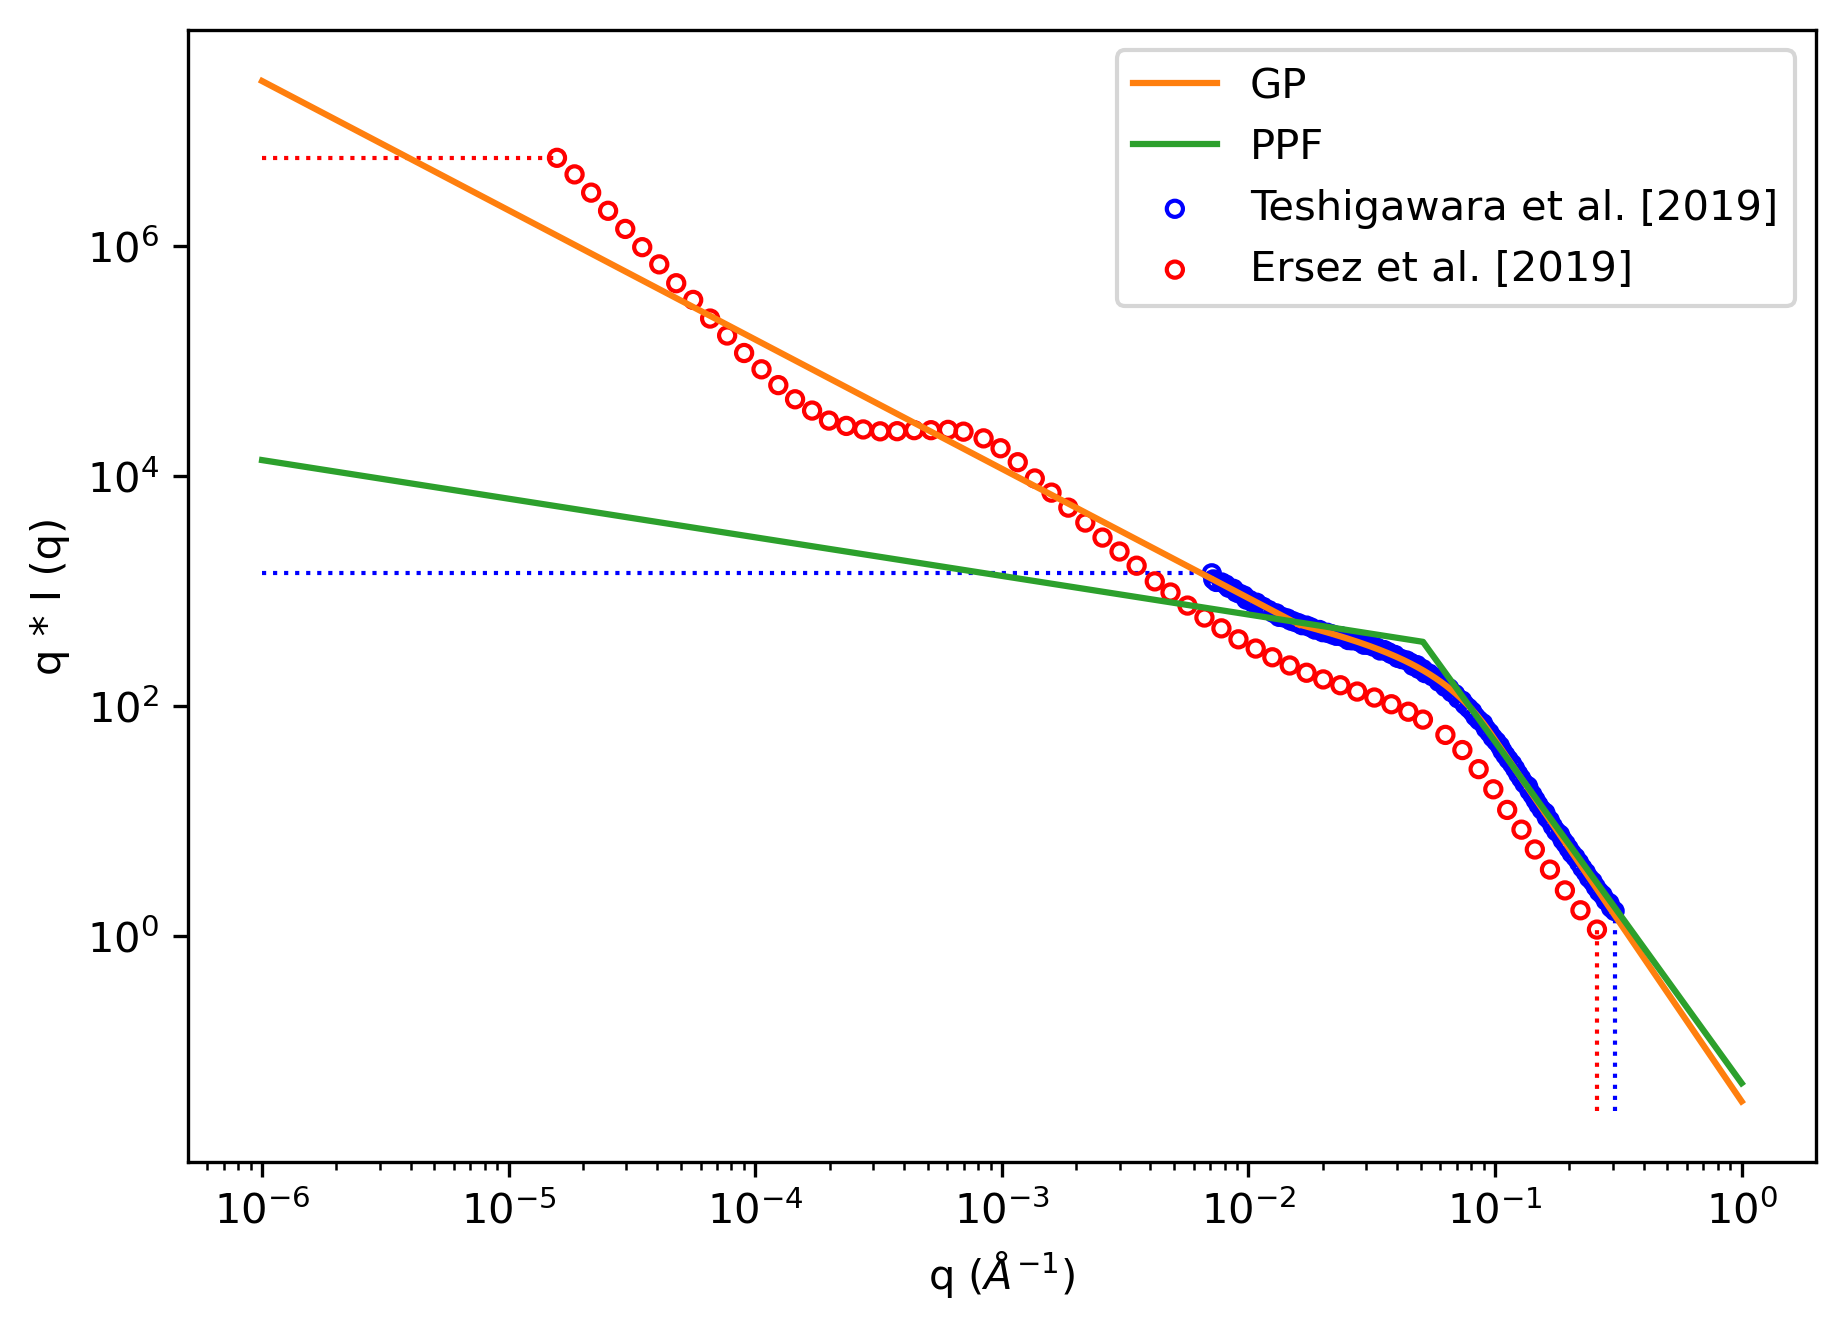

In [55]:
fig, ax = plt.subplots(1,1, figsize=(7, 5), dpi=300)
q1=0.016
mask_fit_PL = (data["q"]>0.0072) & (data["q"]<q1)
mask_fit_guinierANDporod = (data["q"]>q1) & (data["q"]<0.3)

popt,pcov = curve_fit(GuinierANDPorod,
                      data["q"][mask_fit_guinierANDporod],
                      data["I"][mask_fit_guinierANDporod], 
                      p0=[1e2,1.4,16,3.7,],
                      bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr = np.sqrt(np.diag(pcov))
print(popt)

def power_law2(x,p):
    C = popt[0]*np.power(q1,p-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
    return C*np.power(x,-p)

popt2,pcov2 = curve_fit(power_law2,
                      data["q"][mask_fit_PL],
                      data["I"][mask_fit_PL], 
                      p0=[1],
                      bounds=((0), (np.inf)))
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data["q"],data["I"]*data["q"],s=15,facecolors='none',edgecolors="b",label="Teshigawara et al. [2019]")#
plt.scatter(data_ersez["q"],data_ersez["I"]*data_ersez["q"],s=15,facecolors='none',edgecolors="r",label="Ersez et al. [2019]")

x_fit = [x for x in np.linspace(q1,1,1000)]
y_fit=GuinierANDPorod(pd.Series(x_fit),*popt)
y_fit = x_fit*y_fit
x_fit2 =[x for x in np.linspace(1e-6,q1,100)]
y_fit2=power_law2(pd.Series(x_fit2),*popt2)
y_fit2 = x_fit2*y_fit2
A1=132.869
b1=1.33605
A2=0.0519763
b2=3.97314
Q0=0.0510821

x_fit_PPF = [x for x in np.logspace(-6,0,10000)]
y_fit_PPF = [x*piecewise_power(x,A1,b1,A2,b2,Q0) for x in x_fit_PPF]

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"
label_string_pl = f" p={popt2[0]:.2f}$\pm${perr2[0]:.2f}"

#Graphical decorators
#ymin, ymax = ax.get_ylim()
#xmin, xmax = ax.get_xlim()
#plt.vlines(q1,ymin,ymax)
#ax.annotate(r'$q_1$',
#            xy=(q1+0.001,0.03)
#           )
#ax.annotate('Power Law\n'+r'C$q^{-p}$', 
#            xy=(0.006,1e3)
#            )
#plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
#q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
#B = np.power(q2,popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
#C = popt[0]*np.power(q1,popt2[0]-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
#print("q2: ",q2, " C: ",C, " B: ",B)
#print("Relative diff. @q2: ",(GuinierANDPorod(pd.Series([0.015]),*popt)[0] - power_law2(pd.Series([0.015]),*popt2)[0])/GuinierANDPorod(pd.Series([0.015]),*popt)[0])
#plt.vlines(q2,ymin,ymax)
#ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$", 
#            xy=(0.02,1e2)
#            )
#ax.annotate(f'$q_2$', 
#            xy=(q2+0.007,0.03)
#            )
#plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
#plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
#ax.annotate('Porod\n'+r'B$q^{-m}$', 
#            xy=(0.15,1e3)
#            )

plt.hlines(y=data["I"].iat[0]*data["q"].iat[0],xmin=1e-6,xmax=data["q"].iat[0],color="b",linewidth=1,linestyles=":",zorder=0)
plt.vlines(x=data["q"].iat[-1],ymin=3e-2,ymax=data["I"].iat[-1]*data["q"].iat[-1],color="b",linewidth=1,linestyles=":",zorder=0)
plt.hlines(y=data_ersez["I"].iat[0]*data_ersez["q"].iat[0],xmin=1e-6,xmax=data_ersez["q"].iat[0],color="r",linewidth=1,linestyles=":",zorder=0)
plt.vlines(x=data_ersez["q"].iat[-1],ymin=3e-2,ymax=data_ersez["I"].iat[-1]*data_ersez["q"].iat[-1],color="r",linewidth=1,linestyles=":",zorder=0)
plt.plot(x_fit,y_fit, c="tab:orange", label="GP")
plt.plot(x_fit2,y_fit2, c="tab:orange",label=None)
plt.plot(x_fit_PPF,y_fit_PPF, c="tab:green",label="PPF")
plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("q * I (q)")
plt.yscale("log")
#plt.grid(ls=":",which="both")
#plt.savefig("Teshi_GP_and_PL.png",dpi=300)
plt.show()

### Simple model fit

In [45]:
def simple(x,A):
    return A * 25.3e-3/x

In [61]:
cols = ["E", "xs"]
data_vesuvio = pd.read_csv("vesuvio.dat",names=cols,sep=" ",skiprows=1)
data_teshi_xs = pd.read_csv("teshi.dat",names=cols,sep=" ",skiprows=1)

[8.34006915]
[11.97649673]


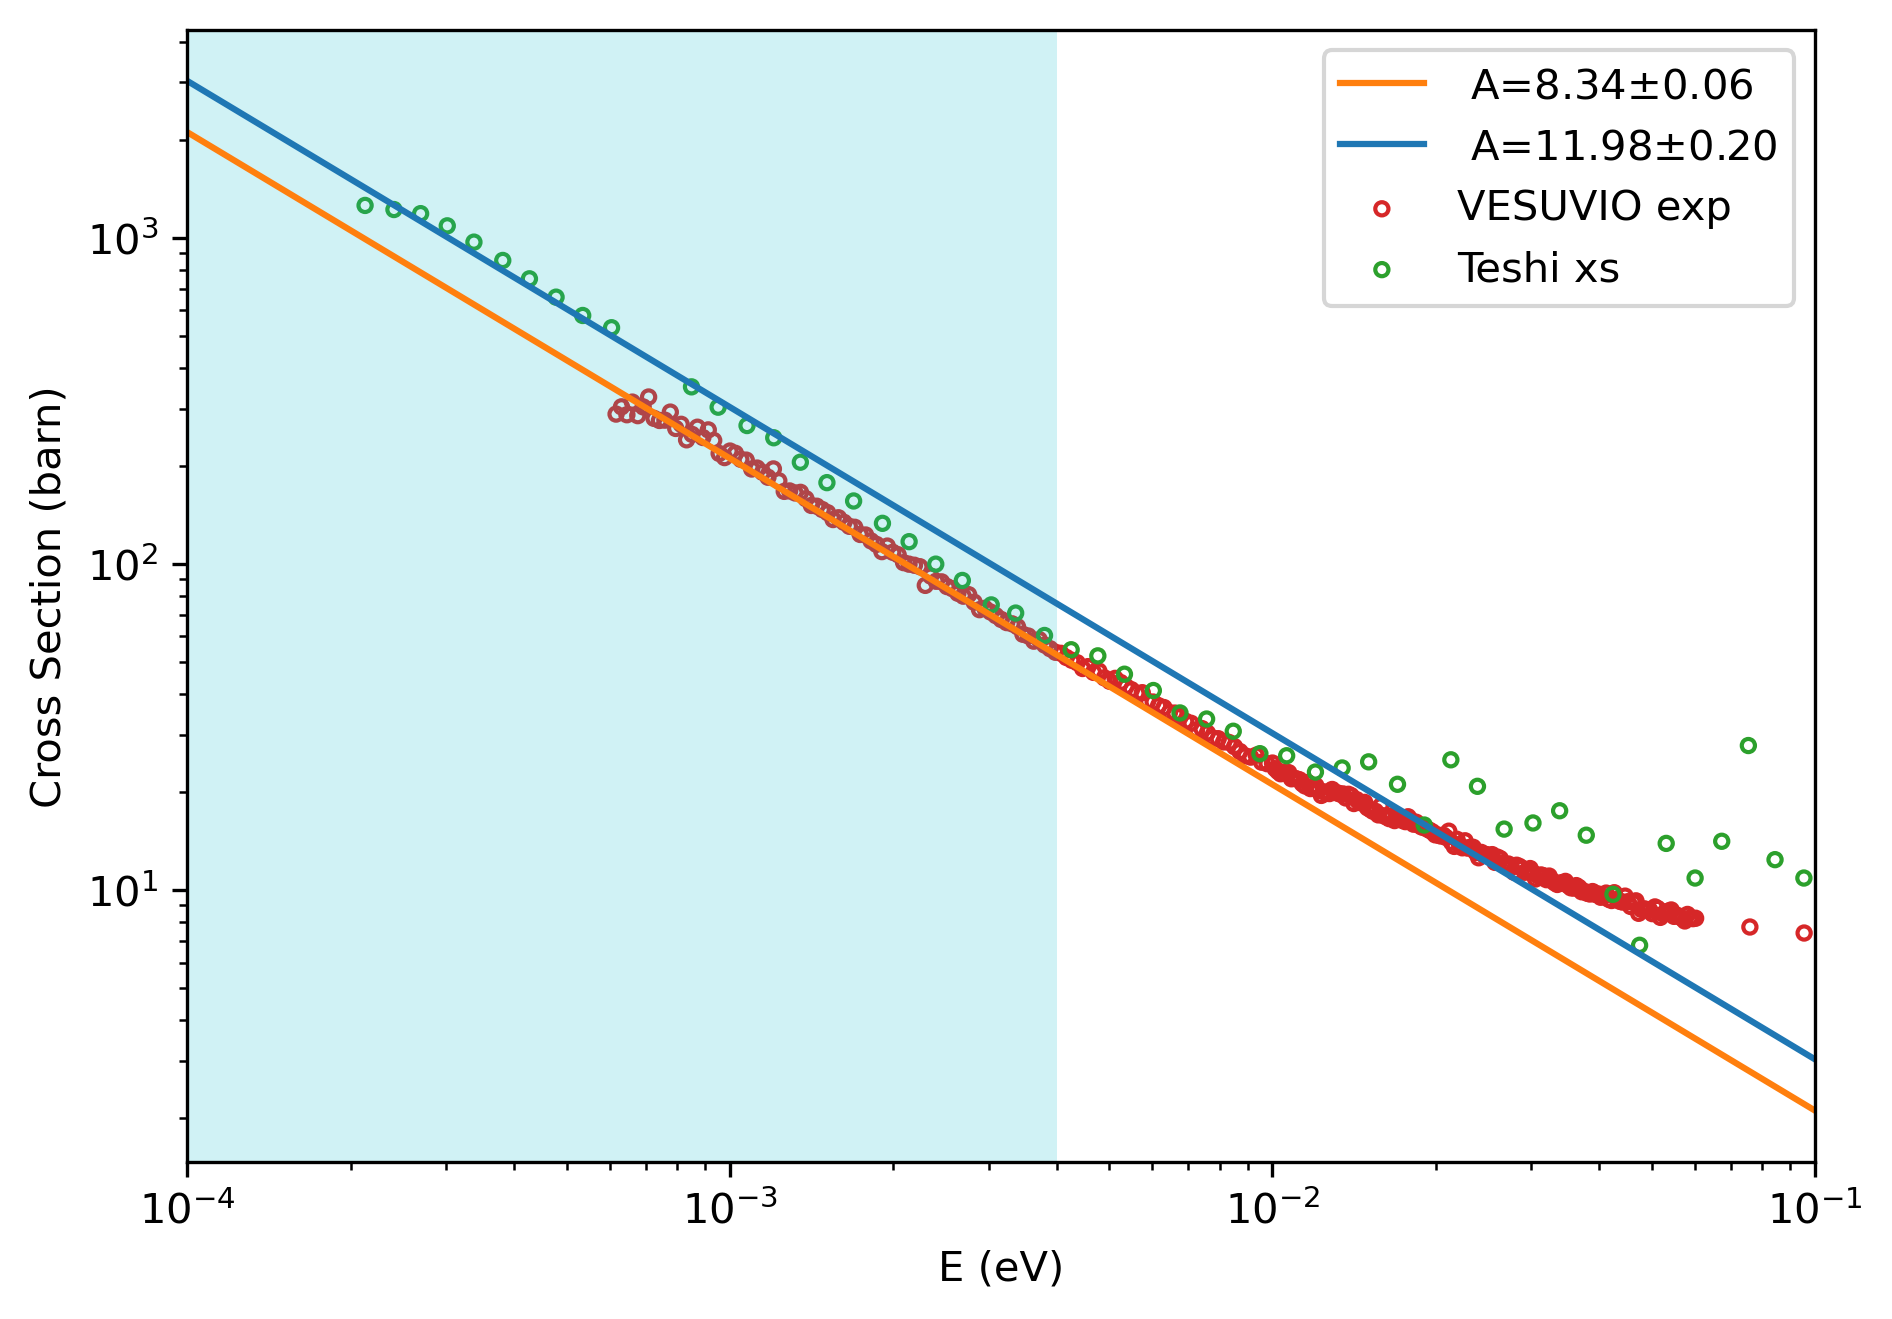

In [113]:
fig, ax = plt.subplots(1,1, figsize=(7, 5), dpi=300)
E_fit=4e-3
mask_vesuvio = data_vesuvio["E"]<E_fit
mask_teshi = data_teshi_xs["E"]<E_fit
popt,pcov = curve_fit(simple,
                      data_vesuvio["E"][mask_vesuvio],
                      data_vesuvio["xs"][mask_vesuvio], 
                      p0=[8],
                      #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr = np.sqrt(np.diag(pcov))
print(popt)

popt2,pcov2 = curve_fit(simple,
                      data_teshi_xs["E"][mask_teshi],
                      data_teshi_xs["xs"][mask_teshi], 
                      p0=[8],
                      #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data_vesuvio["E"],data_vesuvio["xs"],s=10,facecolors='none',edgecolors="tab:red",label="VESUVIO exp")
plt.scatter(data_teshi_xs["E"],data_teshi_xs["xs"],s=10,facecolors='none',edgecolors="tab:green",label="Teshi xs")

x_fit = [x for x in np.logspace(-4,-1,1000)]
y_fit=simple(pd.Series(x_fit),*popt)
y_fit2=simple(pd.Series(x_fit),*popt2)


label_string = f" A={popt[0]:.2f}$\pm${perr[0]:.2f}"
label_string2 = f" A={popt2[0]:.2f}$\pm${perr2[0]:.2f}"
plt.plot(x_fit,y_fit, c="tab:orange", label=label_string)
plt.plot(x_fit,y_fit2, c="tab:blue", label=label_string2)

xmin, xmax = ax.get_xlim()
plt.axvspan(xmin,E_fit, facecolor='tab:cyan', alpha=0.2)

plt.xlim(1e-4,1e-1)
plt.legend()
plt.xscale("log")
plt.xlabel("E (eV)")
plt.ylabel("Cross Section (barn)")
plt.yscale("log")
#plt.grid(ls=":",which="both")
#plt.savefig("Teshi_GP_and_PL.png",dpi=300)
plt.show()

In [201]:
def first_Born_approx(x, R):
    k =  0.6947*np.sqrt(x*1e+3)
    #h_bar = 1.054571817e-34 ;//[J*s] <- Reduced planck constant
    #m = 1.674927498e-27;// [Kg] <- neutron mass
    #V = 290.0e-9*1.60218e-19;// [J]
    #2*pi*(2mV/h_bar^2)^2 =   1.2307e+33 [1/m^4]
    physical_constant = 1.2307e-07
    R *= 10 # converto to AA
    _2kr = 2 * k * R;
    I = 0.25 * (1 - 1 / (_2kr * _2kr) + np.sin(2 * _2kr) / (_2kr * _2kr * _2kr) - np.sin(_2kr) * np.sin(_2kr) / (_2kr * _2kr * _2kr * _2kr))
    SANS_xs = physical_constant*np.power(R, 6) / (k * k * R * R) * I * 1e8 #convert to barn
    return SANS_xs

In [184]:
print(np.power(24*1e-10,6)*1.2307e+33/(k*k*24*24)/4*1e24)

0.4230313702366655


In [182]:
k =  0.6947*np.sqrt(0.5*1e+3)
print(np.power(24,6)*1.2307e-07/(k*k*24*24)/4*1e4)

0.42303137023666554


In [180]:
first_Born_approx(0.5, 2.4)

0.423030610195721

In [199]:
import scipy.constants as c
2*c.pi*c.hbar*c.hbar/c.m_n*6.65*c.femto*1.7602606161532054e+17

3.0480662462873386e-19

In [200]:
c.Avogadro

6.02214076e+23

In [156]:
def en2k(x):
    return 0.6947*np.sqrt(x*1e+3)

In [161]:
def rolando(x,R):
    return 0.006872*np.power(R,4.015)/x

In [164]:
physical_constant = 1.2307e+33 #[1/m^4]
energy_conv_const = (.6947*.6947) #[AA^2/meV]
print(physical_constant*1e-40/4/energy_conv_const)

6.375255748406539e-08


[0.80382327]
[0.88320955]


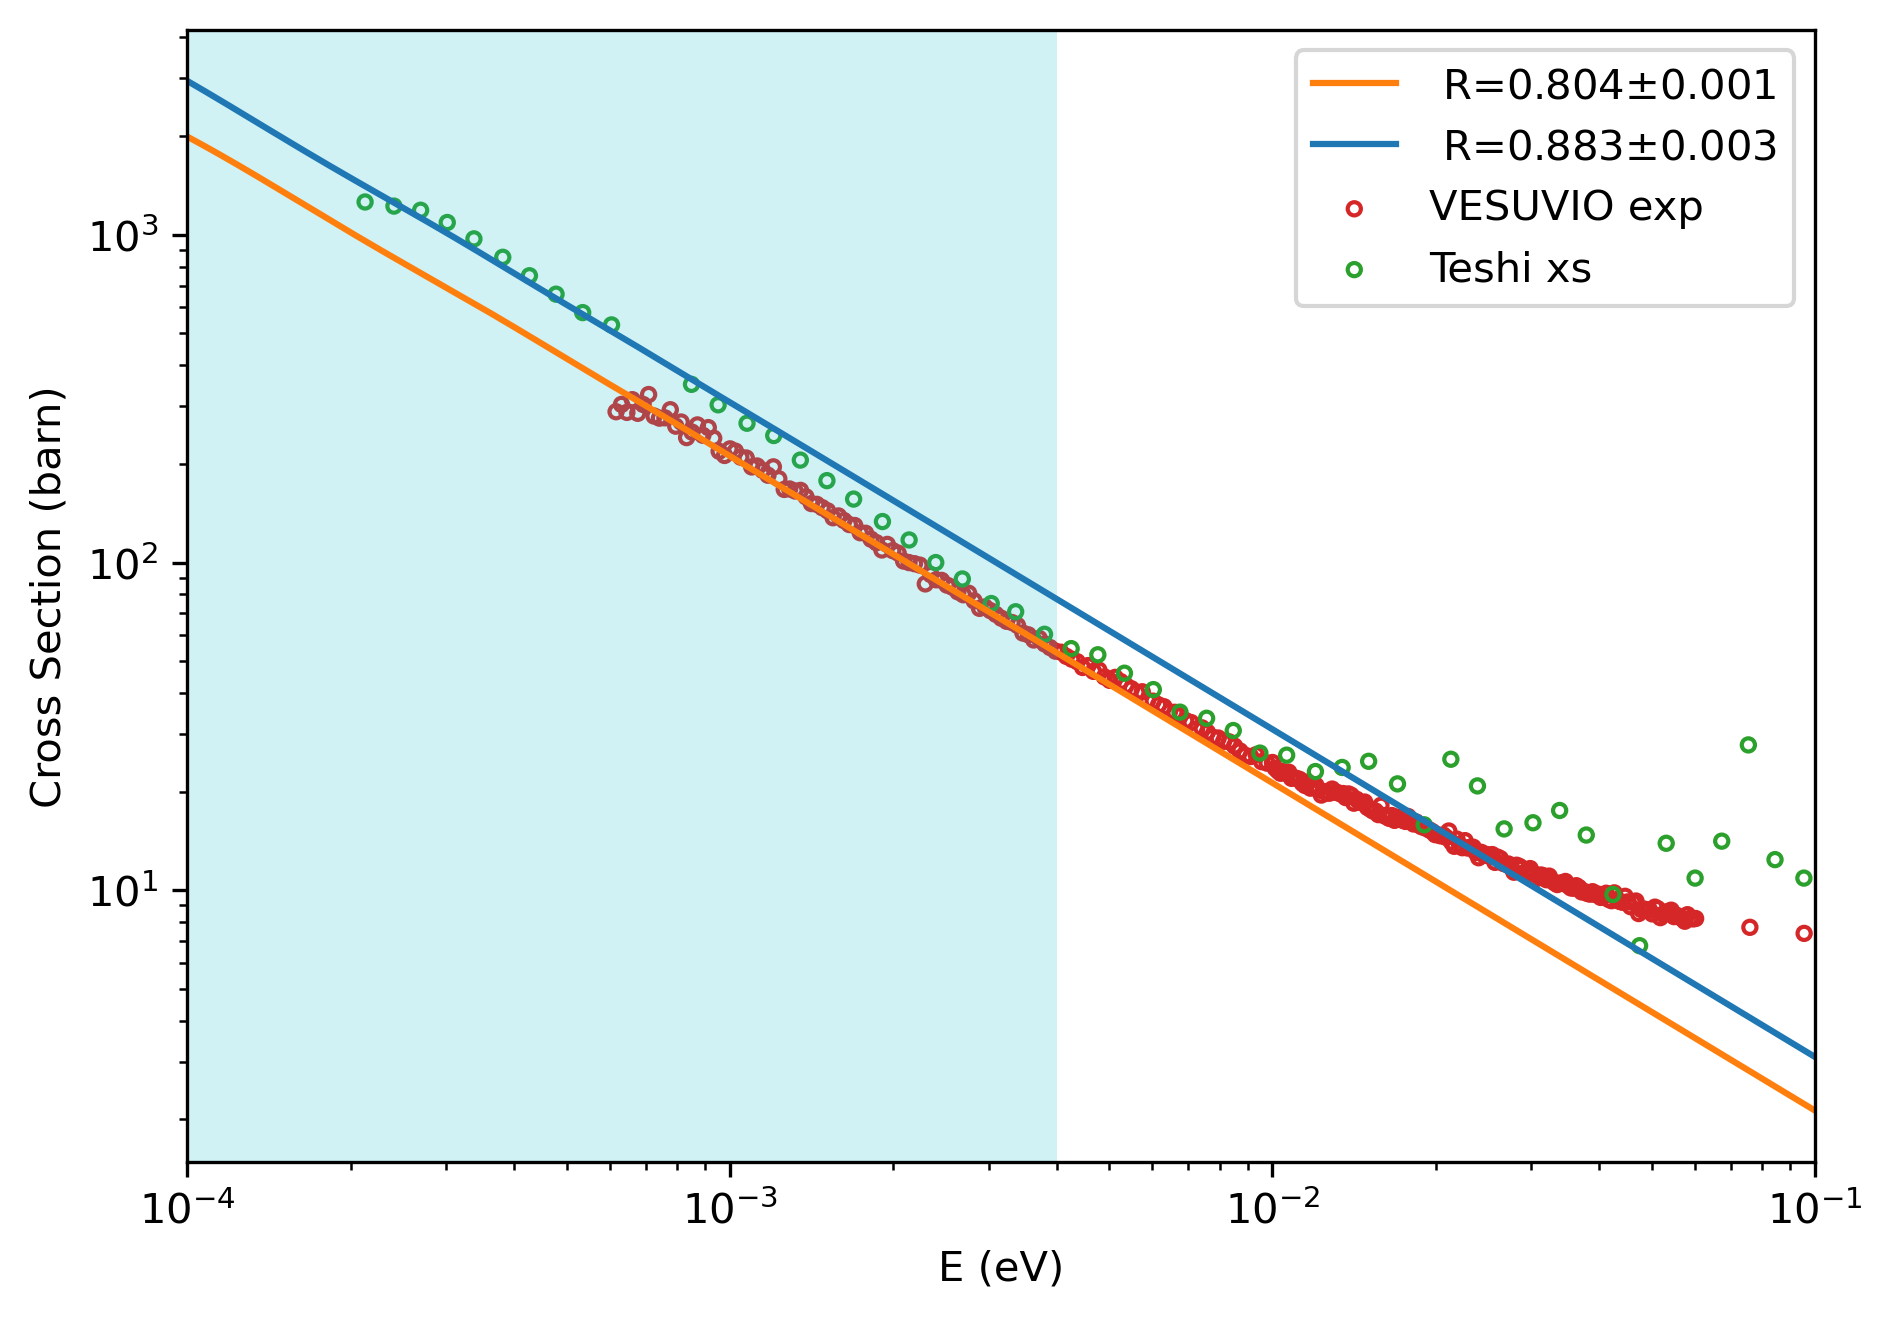

In [202]:
fig, ax = plt.subplots(1,1, figsize=(7, 5), dpi=300)
E_fit=4e-3
mask_vesuvio = data_vesuvio["E"]<E_fit
mask_teshi = data_teshi_xs["E"]<E_fit
popt,pcov = curve_fit(first_Born_approx,
                      data_vesuvio["E"][mask_vesuvio],
                      data_vesuvio["xs"][mask_vesuvio], 
                      p0=[0.2],
                      #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr = np.sqrt(np.diag(pcov))
print(popt)

popt2,pcov2 = curve_fit(first_Born_approx,
                      data_teshi_xs["E"][mask_teshi],
                      data_teshi_xs["xs"][mask_teshi], 
                      p0=[0.2],
                      #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                          )
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data_vesuvio["E"],data_vesuvio["xs"],s=10,facecolors='none',edgecolors="tab:red",label="VESUVIO exp")
plt.scatter(data_teshi_xs["E"],data_teshi_xs["xs"],s=10,facecolors='none',edgecolors="tab:green",label="Teshi xs")

x_fit = [x for x in np.logspace(-4,-1,10000)]
y_fit=first_Born_approx(pd.Series(x_fit),*popt)
y_fit2=first_Born_approx(pd.Series(x_fit),*popt2)


label_string = f" R={popt[0]:.3f}$\pm${perr[0]:.3f}"
label_string2 = f" R={popt2[0]:.3f}$\pm${perr2[0]:.3f}"
plt.plot(x_fit,y_fit, c="tab:orange", label=label_string)
plt.plot(x_fit,y_fit2, c="tab:blue", label=label_string2)

xmin, xmax = ax.get_xlim()
plt.axvspan(xmin,E_fit, facecolor='tab:cyan', alpha=0.2)

plt.xlim(1e-4,1e-1)
plt.legend()
plt.xscale("log")
plt.xlabel("E (eV)")
plt.ylabel("Cross Section (barn)")
plt.yscale("log")
#plt.grid(ls=":",which="both")
plt.savefig("FirstBornApp_xs.png",dpi=300)
plt.show()

### OLD

In [11]:
from scipy.special import gammaincc, gamma,gammainc
def gamma_inc(a,x):
    return gamma(a)*gammaincc(a,x)
def indef_int_guinier(q):
    A=67.47
    s=1.5
    rg=14.73173127
    c = rg**2/(3-s)
    if(q!=0):
        return -(c)**(s/2-1)*gamma_inc(1-s/2,c*q**2)/2
    else:
        return -(c**(s/2-1)*gamma(1-s/2))/2
def indef_int_guinier2(q):
    A=67.47
    s=1.5
    rg=14.73173127
    c = rg**2/(3-s)
    return (c)**(s/2-1)*gamma(1-s/2)*gammainc(1-s/2,c*q**2)/2


In [12]:
(indef_int_guinier(0.0072) - indef_int_guinier(0))

0.16945158675552735

In [13]:
indef_int_guinier2(0.0072)

0.16945158675552738